Data Sources
-----------
U.S. Energy Information Administration, Crude Oil Prices: Brent - Europe [DCOILBRENTEU], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DCOILBRENTEU, October 20, 2018.


U.S. Energy Information Administration, Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma [DCOILWTICO], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DCOILWTICO, October 20, 2018.

In [195]:
import pandas as pd

# df_brent = pd.read_csv('DCOILBRENTEU.csv') 
# df_wti = pd.read_csv('DCOILWTICO.csv')

df_brent = pd.read_csv("https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=DCOILBRENTEU&scale=left&cosd=1987-05-20&coed=2018-10-15&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2018-10-20&revision_date=2018-10-20&nd=1987-05-20")
df_wti = pd.read_csv("https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=DCOILWTICO&scale=left&cosd=1986-01-02&coed=2018-10-15&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2018-10-20&revision_date=2018-10-20&nd=1986-01-02")

df_data = df_brent.join(df_wti.set_index('DATE'), on='DATE', how='inner')
df_data.head()

,DATE,DCOILBRENTEU,DCOILWTICO
0,1987-05-20,18.63,19.75
1,1987-05-21,18.45,19.95
2,1987-05-22,18.55,19.68
3,1987-05-25,18.60,.
4,1987-05-26,18.63,19.35


In [31]:
print ('Original data', df_data.shape)

df_data = df_data[df_data.DCOILBRENTEU != "."]
df_data = df_data[df_data.DCOILWTICO != "."]
df_data = df_data.reset_index()
print ('Data with empty values removed', df_data.shape)

Original data (7854, 4)
Data with empty values removed (7854, 5)


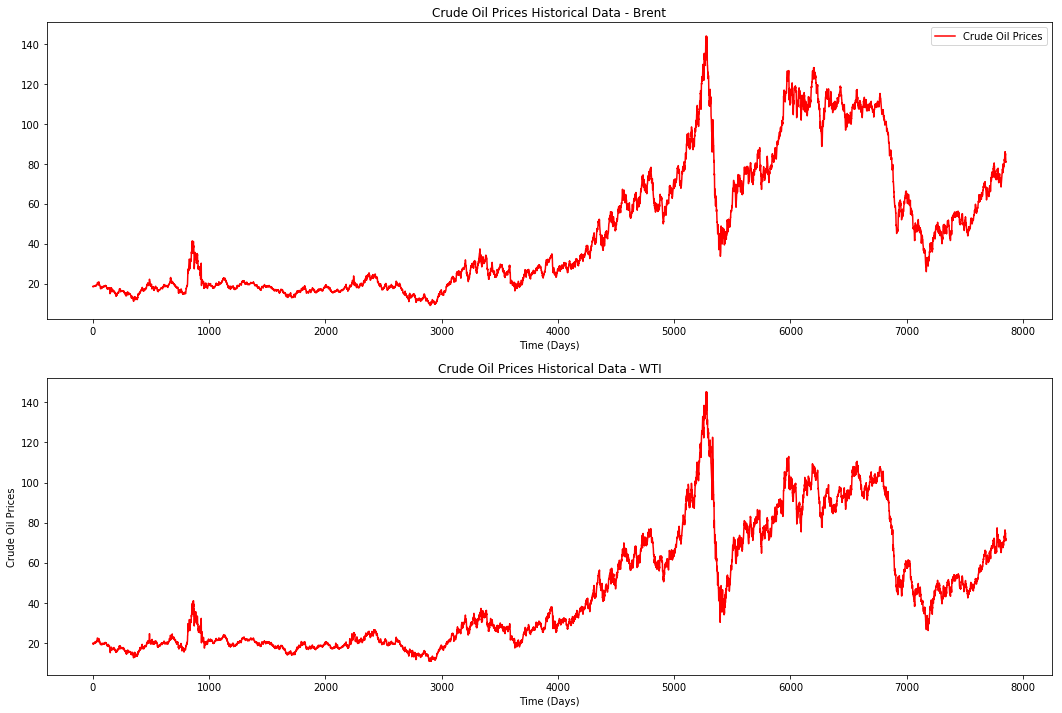

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

# Visualising the Data
plt.figure(figsize=(18,12))

plt.subplot(2, 1, 1)
plt.title('Crude Oil Prices Historical Data - Brent')
plt.plot(df_data[['DCOILBRENTEU']].astype(float), color = 'red', label = 'Crude Oil Prices')
plt.xlabel('Time (Days)')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Crude Oil Prices Historical Data - WTI')
plt.plot(df_data[['DCOILWTICO']].astype(float), color = 'red', label = 'Crude Oil Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Crude Oil Prices')
plt.show()

In [32]:
#import packages
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.models import load_model

Using TensorFlow backend.


Batch-size and trainings-set size
-------------------------------

With **stateful LSTMs** the trainings-set size must be divisible without remainder by the batch-size (modulo = 0)

In [176]:
# defining the batch size and number of epochs
batch_size = 64
epochs = 120
timesteps = 30

In [47]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    length = int(length)
    
    train_length = length - length % batch_size
    
    return (train_length)

In [48]:
length = get_train_length(df_data, batch_size, 0.1)
print (length)

7040


In [57]:
#Adding timesteps * 2
upper_train = length + timesteps*2
df_data_train = df_data[0:upper_train]
training_set = df_data_train.iloc[:,3:5].values
print (training_set.shape)
training_set

(7100, 2)


array([['18.63', '19.75'],
       ['18.45', '19.95'],
       ['18.55', '19.68'],
       ...,
       ['51.66', '47.86'],
       ['52.13', '49.46'],
       ['52.08', '49.67']], dtype=object)

In [60]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
print (training_set_scaled.shape)
training_set_scaled

(7100, 2)


array([[0.07067112, 0.06639899],
       [0.0693363 , 0.06788609],
       [0.07007786, 0.0658785 ],
       ...,
       [0.31560994, 0.27541081],
       [0.31909529, 0.28730761],
       [0.31872451, 0.28886906]])

In [62]:
X_train = []
y_train = []

# Creating a data structure with n timesteps

print (length + timesteps)
for i in range(timesteps, length + timesteps): 
    X_train.append(training_set_scaled[i-timesteps:i,0:2])
    y_train.append(training_set_scaled[i:i+timesteps,0:2])

print (len(X_train))
print (len (y_train))
print (np.array(X_train).shape)
print (np.array(y_train).shape)

7070
7040
7040
(7040, 30, 2)
(7040, 30, 2)


In [65]:
# Reshaping
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 2))
print (X_train.shape)
print (y_train.shape)

(7040, 30, 2)
(7040, 30, 2)


In [72]:
upper_train

7100

In [128]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
    return (max(test_length_values))

In [129]:
test_length = get_test_length(df_data, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print (testset_length)

7740
640


In [130]:
print (upper_train, upper_test, len(df_data))

7100 7800 7854


In [131]:
# construct test set

#subsetting
df_data_test = df_data[upper_train:upper_test] 
test_set = df_data_test.iloc[:,3:5].values

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0:2])
X_test = np.array(X_test)

#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))

In [105]:
# Building the LSTM
# Importing the Keras libraries and packages

from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model
import h5py

In [182]:
# Initialising the LSTM Model with MSE Loss Function

inputs_1_mse = Input(batch_shape=(batch_size,timesteps,2))
lstm_1_mse = LSTM(20, stateful=True, return_sequences=True)(inputs_1_mse)
lstm_2_mse = LSTM(20, stateful=True, return_sequences=True)(lstm_1_mse)

output_1_mse = Dense(units = 2)(lstm_2_mse)

regressor_mse = Model(inputs=inputs_1_mse, outputs = output_1_mse)

regressor_mse.compile(optimizer='adam', loss = 'mse', metrics=['accuracy'])
regressor_mse.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (64, 30, 2)               0         
_________________________________________________________________
lstm_9 (LSTM)                (64, 30, 20)              1840      
_________________________________________________________________
lstm_10 (LSTM)               (64, 30, 20)              3280      
_________________________________________________________________
dense_5 (Dense)              (64, 30, 2)               42        
Total params: 5,162
Trainable params: 5,162
Non-trainable params: 0
_________________________________________________________________


In [183]:
#some learners constantly reported 502 errors in Watson Studio. 
#This is due to the limited resources in the free tier and the heavy resource consumption of Keras.
#This is a workaround to limit resource consumption

# from keras import backend as K

# K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)))


In [197]:
for i in range(epochs):
    print("Epoch: " + str(i))
    regressor_mse.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    regressor_mse.reset_states()

Epoch: 0
Epoch 1/1
7040/7040 [==============================] - 16s 2ms/step - loss: 0.0027 - acc: 0.6547
Epoch: 1
Epoch 1/1
6016/7040 [========================>.....] - ETA: 2s - loss: 0.0018 - acc: 0.5444

KeyboardInterrupt: 

In [185]:
#regressor_mse = load_model(filepath="models/my_model_with_mse.h5")

In [186]:
predicted_bcg_values_test_mse = regressor_mse.predict(X_test, batch_size=batch_size)
regressor_mse.reset_states()

shape = predicted_bcg_values_test_mse.shape
print(shape)

predicted_bcg_values_test_mse = np.reshape(predicted_bcg_values_test_mse, 
                                       (shape[0] * shape[1], 2))
print (predicted_bcg_values_test_mse.shape)

predicted_bcg_values_test_mse = sc.inverse_transform(predicted_bcg_values_test_mse)
predicted_bcg_values_test_mse = np.reshape(predicted_bcg_values_test_mse, shape)
print (predicted_bcg_values_test_mse.shape)

pred_mse = []

for j in range(0, testset_length - timesteps):
    pred_mse = np.append(pred_mse, predicted_bcg_values_test_mse[j, timesteps-1])

pred_mse = np.reshape(pred_mse, (testset_length - timesteps, 2))
print (pred_mse.shape)

(640, 30, 2)
(19200, 2)
(640, 30, 2)
(610, 2)


In [187]:
test_set

array([['50.95', '47.09'],
       ['48.94', '46.70'],
       ['48.25', '46.63'],
       ...,
       ['74.51', '71.59'],
       ['74.84', '68.66'],
       ['74.99', '71.19']], dtype=object)

In [188]:
pred_mse

array([[45.29533768, 42.91471481],
       [45.34676743, 42.83984756],
       [45.94171524, 43.28089523],
       ...,
       [73.0625    , 65.16683197],
       [73.37049103, 65.43254089],
       [72.62751007, 64.62799072]])

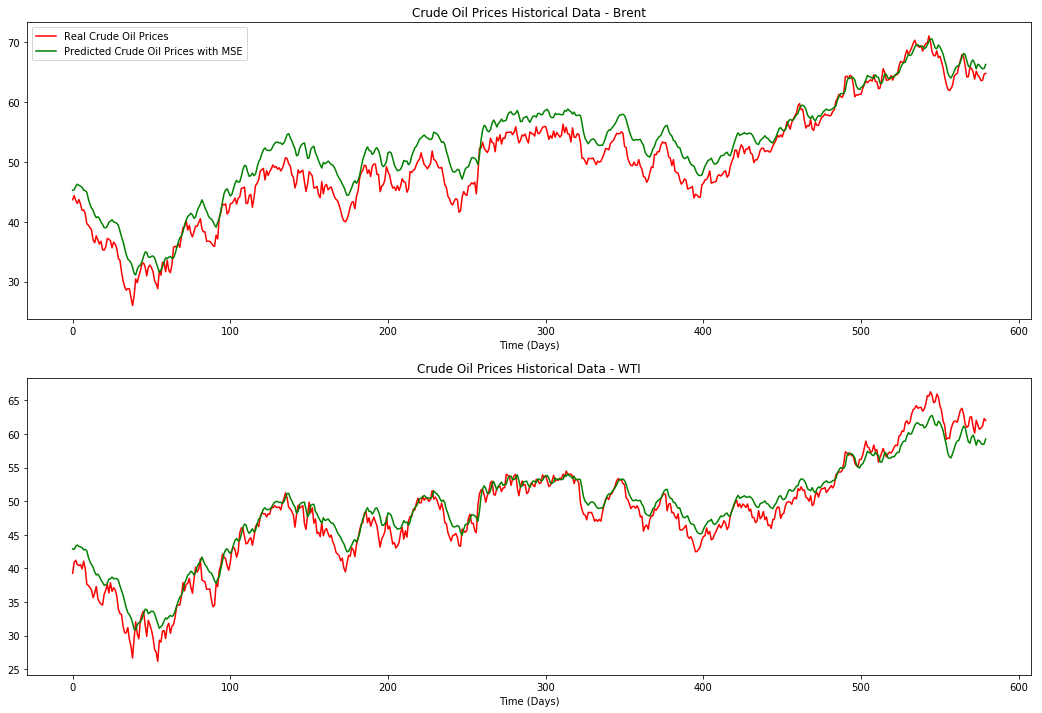

In [189]:
# Visualising the Data
plt.figure(figsize=(18,12))

plt.subplot(2, 1, 1)
plt.title('Crude Oil Prices Historical Data - Brent')
plt.plot(test_set[timesteps:len(pred_mse),0].astype(float), color = 'red', label = 'Real Crude Oil Prices')
plt.plot(pred_mse[0:len(pred_mse) - timesteps, 0].astype(float), color = 'green', label = 'Predicted Crude Oil Prices with MSE')
plt.xlabel('Time (Days)')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Crude Oil Prices Historical Data - WTI')
plt.plot(test_set[timesteps:len(pred_mse),1].astype(float), color = 'red', label = 'Real Crude Oil Prices')
plt.plot(pred_mse[0:len(pred_mse) - timesteps, 1].astype(float), color = 'green', label = 'Predicted Crude Oil Prices with MSE')
plt.xlabel('Time (Days)')
plt.show()

In [190]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps]))
print(rmse)

2.688041747709647


In [191]:
mean = np.mean(np.float64(test_set[timesteps:len(pred_mse)]))
print (mean)

49.017327586206896


In [192]:
rmse/mean * 100

5.483860259379057

In [193]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_set[timesteps:len(pred_mse)], pred_mse[0:len(pred_mse) - timesteps])
print(mae)

2.2003343327620923


In [194]:
mae/mean * 100

4.488890849653846

In [54]:
regressor_mse.save(filepath="my_model_with_mse_30_ts.h5")

In [55]:
!pwd
!ls models/*.h5

'pwd' is not recognized as an internal or external command,
operable program or batch file.
'ls' is not recognized as an internal or external command,
operable program or batch file.


In [56]:
!dir *.h5

 Volume in drive C is Local Disk
 Volume Serial Number is D079-03A9

 Directory of C:\Users\Oleg Kholod\Downloads

10/19/2018  12:50 AM            49,264 my_model_with_mae_30_ts.h5
10/19/2018  08:39 AM            49,312 my_model_with_mse_30_ts.h5
               2 File(s)         98,576 bytes
               0 Dir(s)  829,206,589,440 bytes free
